In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ToyTimeSeries, ReactionDiffusion, HomogeneousReactionDiffusion
from lafomo.models import NeuralOperator
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import Plotter, plot_spatiotemporal_data, tight_kwargs

(1765050, 4)
torch.Size([2, 1681]) torch.Size([1050, 4, 1681]) torch.Size([1050, 4])
params torch.Size([1050, 4])
torch.Size([2, 1681]) torch.Size([2000, 4, 1681]) torch.Size([2000, 4])
params torch.Size([2000, 4])
tensor([0.1000, 0.3000, 0.2050, 0.1000])


C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid.reshape(1, s, s, 2), dtype=torch.float)
C:\Users\Jacob\Documents\proj\lafomo\lafomo\utilities\data.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(data.shape[0], s, s, 4), dtype=torch.float)
C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


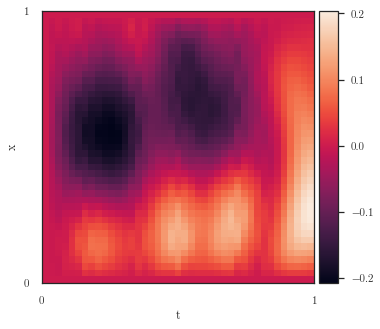

In [2]:
dataset = HomogeneousReactionDiffusion('../../data', one_fixed_sample=False)

ntest = 50

dataset = ReactionDiffusion('../../data', nn_format=True, max_n=4000, ntest=ntest)

i = 20
tx = dataset.data[i][0]
print(dataset.data[i][2])
ts = tx[:, :, 1].unique().sort()[0].numpy()
xs = tx[:, :, 2].unique().sort()[0].numpy()
extent = [ts[0], ts[-1], xs[0], xs[-1]]

plot_spatiotemporal_data(
    [torch.tensor(tx[:, :, 0])],
    extent, nrows=1, ncols=1
)

batch_size = 50
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
if ntest > 0:
    test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)

(328050, 4)
torch.Size([2, 6561]) torch.Size([50, 4, 6561]) torch.Size([50, 4])
params torch.Size([50, 4])
(328050, 4)
torch.Size([2, 6561]) torch.Size([50, 4, 6561]) torch.Size([50, 4])
params torch.Size([50, 4])


C:\Users\Jacob\miniconda3\envs\wishart\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


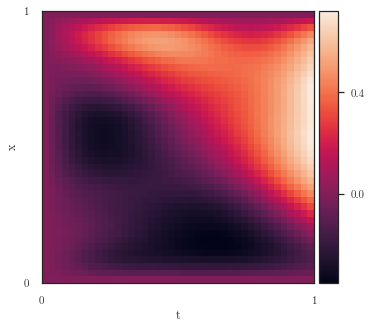

In [3]:
dataset = HomogeneousReactionDiffusion('../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=1, ntest=0)
high_res_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)

dataset = HomogeneousReactionDiffusion('../../data',
                                       one_fixed_sample=False,
                                       highres=True,
                                       nn_format=True,
                                       sub=2, ntest=0)
subsampled_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
i = torch.randint(50, torch.Size([1]))[0]
tx = dataset.data[i][0]

plot_spatiotemporal_data(
    [torch.tensor(tx[:, :, 0])],
    extent, nrows=1, ncols=1
)

block_dim = 2
learning_rate = 1e-3

modes = 12
width = 32
in_channels = 3

torch.Size([50, 4])


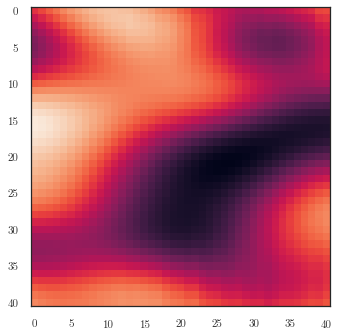

In [4]:
tx, lf, param = next(iter(train_loader))
print(param.shape)
plt.imshow(lf[0,...,0])


In [5]:
ode_data = False
if ode_data:
    width = 20
    modes = 4
    in_channels = 11
    train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test),
                              batch_size=ntest, shuffle=True)

In [6]:
model = NeuralOperator(block_dim, in_channels, modes, width)
print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

1649786


In [ ]:
trainer.train(10);

Epoch 021/030 - Loss: -1996.03 (0.10 0.12 1950.46)


In [12]:
def show_result(model, loader):
    x, y, params = next(iter(loader))
    out, params_out = model(x)

    if block_dim == 1:
        fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
        for i in range(1, 5):
            axes[0].plot(x[0, :, i])#.shape, y.shape)
        axes[1].plot(y[0, :, 0])
        axes[1].plot(out[0, :, 0].detach())
    else:
        num_t = x.shape[1]
        num_x = x.shape[2]

        plot_spatiotemporal_data(
            [
                out[0, ..., 0].detach().view(num_t, num_x),
                y[0, ..., 0].view(num_t, num_x),
                x[0, ..., 0].view(num_t, num_x)
            ],
            extent, nrows=1, ncols=3,
            titles=['Latent (Prediction)', 'Latent (Target)', 'Test input']
        )
        out = out.squeeze()
        y_target = y.squeeze()
        print(params_out[0], params[0])
        print(F.mse_loss(out[...,0], y_target))
        # from lafomo.utilities.torch import smse, q2
        # print(y.shape, f_mean_test.shape)
        # print(smse(y_target, f_mean_test).shape)


tensor([0.4301, 0.2549, 0.0730, 0.1887], grad_fn=<SelectBackward>) tensor([0.2000, 0.3000, 0.1075, 0.0752])
tensor(0.1188, grad_fn=<MseLossBackward>)


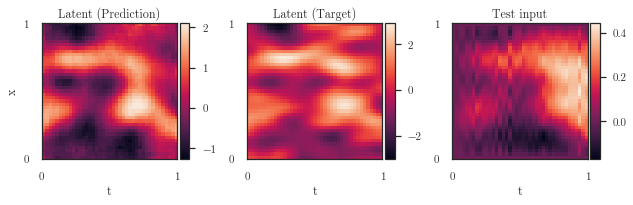

In [16]:
show_result(model, test_loader)

tensor([ 1.0399,  0.9508,  1.8077, -0.0709], grad_fn=<SelectBackward>) tensor([0.3000, 0.3000, 0.1000, 0.0100])
tensor(0.0895, grad_fn=<MseLossBackward>)


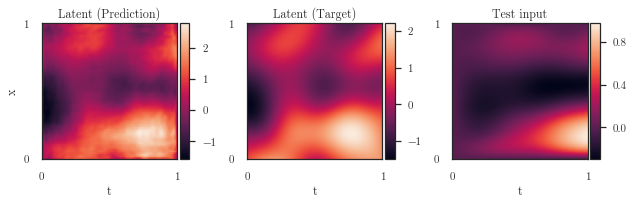

In [19]:
show_result(model, high_res_loader)

In [ ]:
# 0, 3, 6, 8, 48
i = 48
# i = torch.randint(50, torch.Size([1]))[0]
print(i)
x_sub, y_sub = subsampled_loader.dataset[:50]
x, y = high_res_loader.dataset[:50]

out, _ = model(x)
out_sub, _ = model(x_sub)

num_t = x.shape[1]
num_x = x.shape[2]
num_t_sub = x_sub.shape[1]
num_x_sub = x_sub.shape[2]

plot_spatiotemporal_data(
    [
        x[i, ..., 0].view(num_t, num_x).t(),
        out_sub[i, ..., 0].detach().view(num_t_sub, num_x_sub).t(),
        out[i, ..., 0].detach().view(num_t, num_x).t(),
        y_sub[i, ..., 0].view(num_t_sub, num_x_sub).t(),
    ],
    extent, nrows=1, ncols=4, figsize=(12, 4),
    clim=[(x[i,...,0].min(), x[i,...,0].max())] + [(out[i].min(), out[i].max())] * 3,
    titles=['Test input', 'Prediction', 'Super-resolution Prediction', 'Low-res Target']
)
plt.tight_layout()
out = out.squeeze()
y_target = y.squeeze()
plt.savefig('toy48.pdf', **tight_kwargs)

In [ ]:
dataset = ToySpatialTranscriptomics('../../data', one_fixed_sample=True)
train_loader = generate_neural_dataset(dataset, 1, 0)
show_result(model, train_loader)
print(dataset[0][1].shape)
print(dataset.orig_data.shape)

In [ ]:
from lafomo.datasets import LFMDataset
import pandas as pd

print(dataset.data[0][0].shape)
print(dataset.orig_data.shape)
test_loader = generate_neural_dataset(dataset, 10, 0)
show_result(model, test_loader)

In [ ]:
x, y = test_loader.dataset[:50]
i = 0
# out, _ = model(x)
# out_sub, _ = model(x_sub)
print(num_t)
num_t = x.shape[1]
num_x = x.shape[2]
print(x.shape, y.shape)
plot_spatiotemporal_data(
    [
        x[i, ..., 0].view(41, 41).t(),
        # out[i, ..., 0].detach().view(num_t, num_x).t(),
        # y[i, ..., 0].view(41, 41).t(),
    ],
    extent, nrows=1, ncols=1, figsize=(12, 4),
    clim=[(x[i,...,2].min(), x[i,...,2].max())],#, (y[i,...,0].min(), y[i,...,0].max())],
    titles=['x', 'y']
)

In [ ]:
data = dataset.orig_data
print(data.shape)
plt.imshow(data[0, 2].view(41, 41))

In [ ]:
torch.save(model.state_dict(), './saved_model2804.pt')

In [ ]:
path = '../../data/ns_V1e-3_N5000_T50.mat'
from h5py import File

# u shape (50, 64, 64, 5000)
# a shape (64, 64, 5000)
# t shape (50, 1)

f = File(path)
print(f)
print(f['u'])

modes = 4
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 10
runtime = np.zeros(2, )

ntrain = 100
sub = 1
S = 64 // sub
T_in = 10
T = 40
S = 32

# train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
# train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]
train_a = torch.rand((100, 32, 32, 50))[:, :, :, :T_in]
train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
print(train_a.shape)
# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
# 32
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
# 1, 32, 32, 40, 1 (1, S, S, T, 1)
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])
# (1, S, S, T, 1)
print(gridt.shape, gridx.shape)
# for t in range(10):
#     plt.figure()
#     plt.imshow(gridy.squeeze()[:, :, t])
print(gridx.repeat([ntrain,1,1,1,1]).shape)
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
print(train_a.shape)

In [ ]:
weight = torch.rand((width, width, modes, modes))
x_ft = torch.rand((10, width, 41, 21))
out_ft = torch.rand((10, width, 41, 21))
print('weight', weight.shape)
print('x_ft', x_ft.shape)
print('out_ft', out_ft.shape)

In [ ]:
from lafomo.utilities.torch import compl_mul2d
out_ft[:, :, :modes, :modes] = compl_mul2d(
    x_ft[:, :, :modes, :modes], weight
)
first = out_ft.clone()

print(x_ft[:, :, :modes, :modes].shape, weight.permute(1, 0, 2, 3).unsqueeze(0).shape)
out_ft[:, :, :modes, :modes] = torch.matmul(
    x_ft[:, :, :modes, :modes], weight.permute(1, 0, 2, 3)
)
second = out_ft.clone()
print(second.shape)